#Node2Vec

In [3]:
import os

print(os.getcwd())

c:\Users\Usuario\Challenge-Reproducibilidad


In [10]:
%pip install networkx

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.2 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [27]:
import networkx as nx

# Cargar el grafo desde el archivo
G = nx.read_weighted_edgelist('moreno_lesmis/out.moreno_lesmis_lesmis', 
                     comments='%',
                     create_using=nx.Graph())

# Cantidad de nodos y aristas en el grafo
print(f"Número de nodos: {G.number_of_nodes()}")
print(f"Número de aristas: {G.number_of_edges()}")

# Ver un resumen del grafo
print("Nodos:", list(G.nodes))    
print("Aristas:", list(G.edges))  

Número de nodos: 77
Número de aristas: 254
Nodos: ['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '24', '25', '26', '27', '28', '29', '30', '32', '33', '34', '35', '36', '37', '38', '39', '44', '45', '49', '50', '52', '56', '59', '65', '69', '70', '71', '72', '73', '17', '18', '19', '20', '21', '22', '23', '31', '42', '43', '51', '40', '41', '76', '55', '46', '53', '58', '63', '47', '48', '60', '61', '62', '64', '66', '67', '74', '75', '77', '57', '54', '68']
Aristas: [('1', '2'), ('2', '3'), ('2', '4'), ('2', '5'), ('2', '6'), ('2', '7'), ('2', '8'), ('2', '9'), ('2', '10'), ('2', '11'), ('3', '4'), ('3', '11'), ('4', '11'), ('11', '12'), ('11', '13'), ('11', '14'), ('11', '15'), ('11', '16'), ('11', '24'), ('11', '25'), ('11', '26'), ('11', '27'), ('11', '28'), ('11', '29'), ('11', '30'), ('11', '32'), ('11', '33'), ('11', '34'), ('11', '35'), ('11', '36'), ('11', '37'), ('11', '38'), ('11', '39'), ('11', '44'), ('11', '45'), ('11', '49'), ('11

In [31]:
%pip install matplotlib

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.2 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


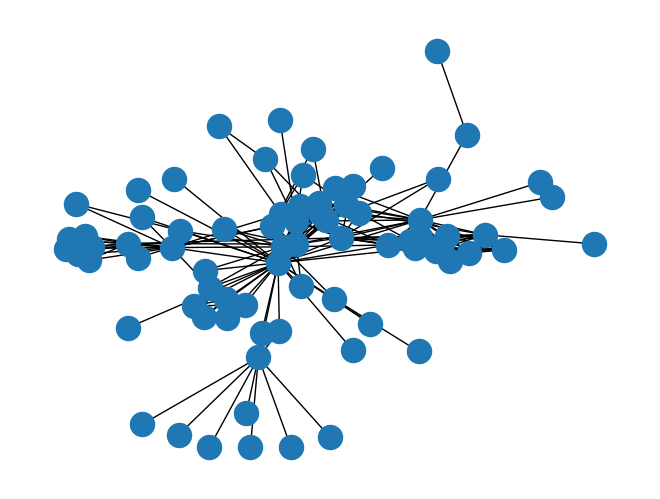

In [32]:
# Visualizemos el grafo
import matplotlib 
nx.draw(G)